In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from DataGenerator2D import DataGenerator2D
from Models import Unet
from Evaluation_matrices import iou, f1, dice_coef, dice_coef_loss
from Federated import scale_model_weights, sum_scaled_weights

In [2]:
#initialize global model
unet = Unet()
global_model = unet.build_model()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D('//PATH TO FIRST CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D('//PATH TO SECOND CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D('//PATH TO THIRD CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_18[0][0]']              
                                )                                                           

 bin_seg (Conv2D)               (None, 256, 256, 1)  17          ['conv2d_35[0][0]']              
                                                                                                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [3]:
lr = 1e-3
counter = 0
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = unet.build_model() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ")
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights('//PATH TO SAVE YOUR FEDERATED WEIGHTS//')
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print(r"Model Saved in //PATH TO SAVE YOUR FEDERATED WEIGHTS//")
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
        
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 195ms/step - loss: 0.8934 - f1: 0.1006 - iou: 0.0564 - dice_coef: 0.1066
Performance Matrix 
11/11 [==============================] - 9s 562ms/step - loss: 0.8820 - f1: 0.1191 - iou: 0.0628 - dice_coef: 0.1179
Model loss imporved from inf to 0.8819869756698608
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\UnetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 6s 180ms/step - loss: 0.8631 - f1: 0.1428 - iou: 0.0751 - dice_coef: 0.1329
Performance Matrix 
11/11 [=============

30/30 [==============================] - 7s 187ms/step - loss: 0.2168 - f1: 0.7897 - iou: 0.6724 - dice_coef: 0.7832
Performance Matrix 
11/11 [==============================] - 7s 610ms/step - loss: 0.2140 - f1: 0.7811 - iou: 0.6612 - dice_coef: 0.7835
Model loss imporved from 0.22289779782295227 to 0.21396975219249725
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\UnetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  10
---------------------------------------------------------------------------------------
30/30 [==============================] - 6s 178ms/step - loss: 0.1987 - f1: 0.8052 - iou: 0.6967 - dice_coef: 0.8013
Performance Matrix 
11/11 [==============================] - 7s 614ms/step - loss: 0.1844 - f1: 0.8105 - iou: 0.7026 - dice_coef: 0.8128
Model loss imporved from 0.21396975219249725 to 0.18438571691513062
Mo

30/30 [==============================] - 7s 185ms/step - loss: 0.0979 - f1: 0.9051 - iou: 0.8555 - dice_coef: 0.9056
Performance Matrix 
11/11 [==============================] - 7s 599ms/step - loss: 0.0937 - f1: 0.9009 - iou: 0.8520 - dice_coef: 0.9039
Model loss imporved from 0.09673546999692917 to 0.09366872161626816
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\UnetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  29
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 192ms/step - loss: 0.0806 - f1: 0.9198 - iou: 0.8750 - dice_coef: 0.9194
Performance Matrix 
11/11 [==============================] - 7s 608ms/step - loss: 0.1046 - f1: 0.8908 - iou: 0.8300 - dice_coef: 0.8937
----------------------------------------------------------------------

30/30 [==============================] - 7s 187ms/step - loss: 0.0609 - f1: 0.9403 - iou: 0.9091 - dice_coef: 0.9391
Performance Matrix 
11/11 [==============================] - 7s 622ms/step - loss: 0.0850 - f1: 0.9112 - iou: 0.8640 - dice_coef: 0.9137
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  39
---------------------------------------------------------------------------------------
30/30 [==============================] - 6s 180ms/step - loss: 0.0627 - f1: 0.9392 - iou: 0.9146 - dice_coef: 0.9373
Performance Matrix 
11/11 [==============================] - 7s 625ms/step - loss: 0.0782 - f1: 0.9161 - iou: 0.8763 - dice_coef: 0.9190
Model loss imporved from 0.08070450276136398 to 0.07821940630674362
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\UnetGlobalWeights.h5
----------------------------------------------------------------------

30/30 [==============================] - 7s 185ms/step - loss: 0.0279 - f1: 0.9737 - iou: 0.9750 - dice_coef: 0.9721
Performance Matrix 
11/11 [==============================] - 7s 607ms/step - loss: 0.0689 - f1: 0.9274 - iou: 0.8955 - dice_coef: 0.9297
Model loss imporved from 0.06935163587331772 to 0.06887856125831604
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\UnetGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  49
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 187ms/step - loss: 0.0364 - f1: 0.9642 - iou: 0.9630 - dice_coef: 0.9636
Performance Matrix 
11/11 [==============================] - 7s 609ms/step - loss: 0.0732 - f1: 0.9228 - iou: 0.8884 - dice_coef: 0.9256
----------------------------------------------------------------------

30/30 [==============================] - 7s 191ms/step - loss: 0.0257 - f1: 0.9747 - iou: 0.9780 - dice_coef: 0.9743
Performance Matrix 
11/11 [==============================] - 7s 613ms/step - loss: 0.0647 - f1: 0.9325 - iou: 0.9044 - dice_coef: 0.9346
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  59
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 188ms/step - loss: 0.0268 - f1: 0.9748 - iou: 0.9764 - dice_coef: 0.9732
Performance Matrix 
11/11 [==============================] - 7s 614ms/step - loss: 0.0621 - f1: 0.9350 - iou: 0.9080 - dice_coef: 0.9368
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  60
--------------------------------

30/30 [==============================] - 7s 188ms/step - loss: -0.0149 - f1: 1.0148 - iou: 1.0595 - dice_coef: 1.0149
Performance Matrix 
11/11 [==============================] - 7s 608ms/step - loss: 0.0518 - f1: 0.9465 - iou: 0.9342 - dice_coef: 0.9488
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  79
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 184ms/step - loss: -0.0114 - f1: 1.0155 - iou: 1.0604 - dice_coef: 1.0146
Performance Matrix 
11/11 [==============================] - 7s 607ms/step - loss: 0.0520 - f1: 0.9471 - iou: 0.9342 - dice_coef: 0.9492
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  80
------------------------------

30/30 [==============================] - 6s 175ms/step - loss: -0.0190 - f1: 1.0197 - iou: 1.0653 - dice_coef: 1.0190
Performance Matrix 
11/11 [==============================] - 7s 608ms/step - loss: 0.0513 - f1: 0.9467 - iou: 0.9352 - dice_coef: 0.9489
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  90
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 193ms/step - loss: -0.0230 - f1: 1.0224 - iou: 1.0745 - dice_coef: 1.0230
Performance Matrix 
11/11 [==============================] - 7s 605ms/step - loss: 0.0518 - f1: 0.9464 - iou: 0.9346 - dice_coef: 0.9486
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  91
------------------------------

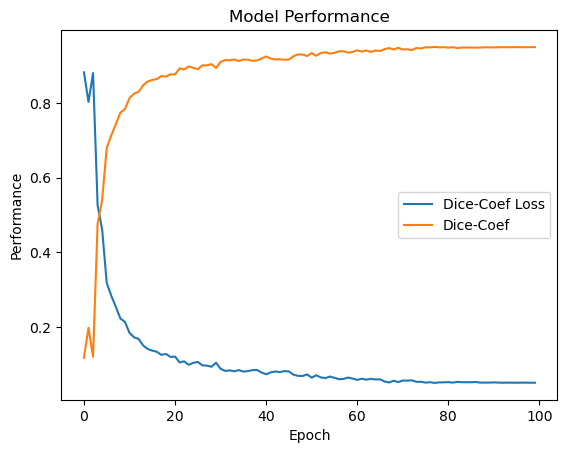

In [4]:
performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

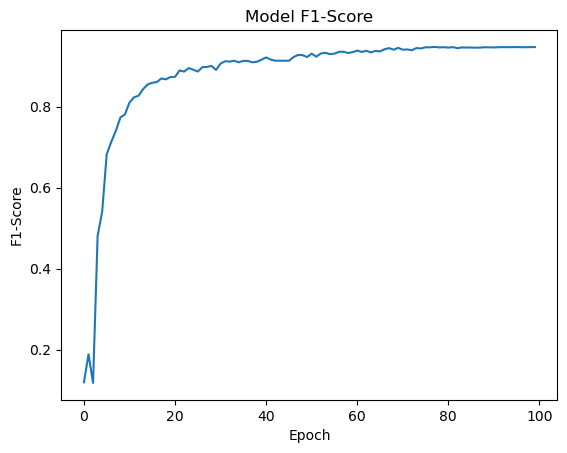

In [5]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

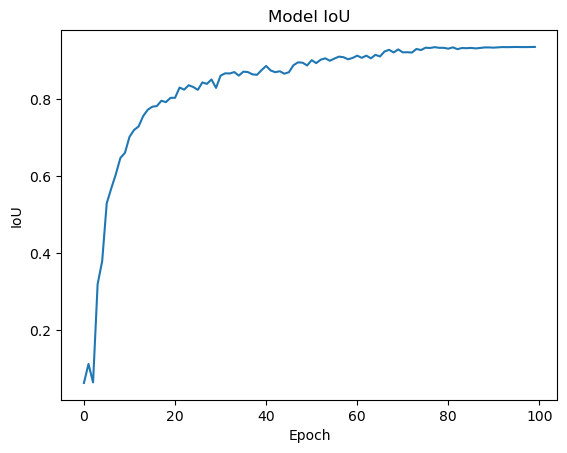

In [6]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [9]:
val_generator = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256,batch_size=128, shuffle=True)
global_model = unet.build_model()
global_model.load_weights('//PATH TO YOUR FEDERATED UNET MODEL WEIGHTS.h5//')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)



3/3 [==============================] - 16s 4s/step - loss: 0.0504 - f1: 0.9443 - iou: 0.9303 - dice_coef: 0.9470


In [10]:
X, y = val_generator.__getitem__(0)
predict = global_model.predict(X)

4/4 [==============================] - 2s 52ms/step


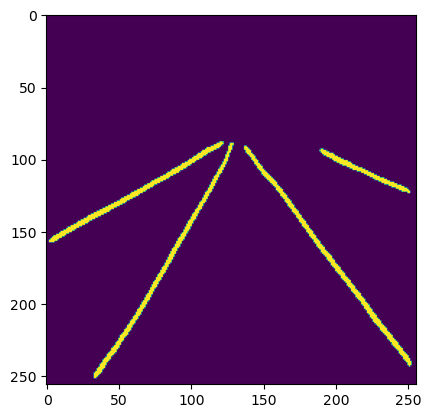

In [11]:
img = predict[2]
plt.imshow(img)

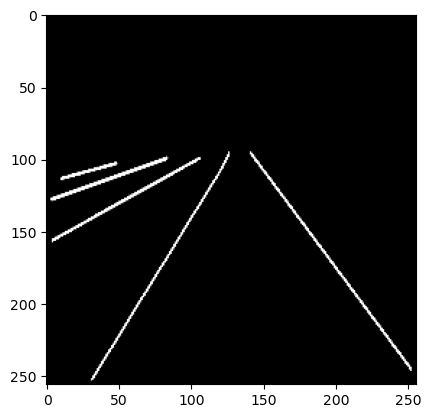

In [12]:
img1 = y[2]
plt.imshow(img1)

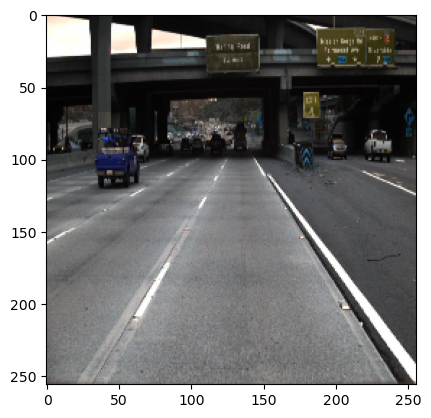

In [13]:
img2 = X[2]
plt.imshow(img2)